# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Statements, Define Flags, and Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Statements, Define Flags, and Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

We will also move all the import statments to this section and we will define flags indicating if the models need to be trained. This will help with re-running the cells in the future. 

In [11]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import __version__
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
from PIL import ImageFile

import os

# these are set to False to prevent the traning algorithms from running. This can be done
#   if the model parameters are saved. It helps reduce run time. 
TRAIN_SCRATCH_MODEL  = True # set to True if the model needs to be trained
TRAIN_TRANSFER_MODEL = True # set to True if the model needs to be trained

%matplotlib inline   

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

# since I am using the Udacity workspace, there is no need to download the datasets. 
# there is an imbalance between the number of human and dog pics 
# this immbalance is even more sever when comparing the numbers of images for dog breeds to humans

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


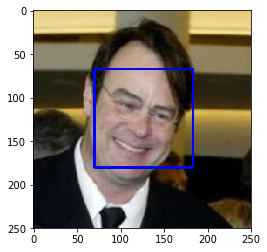

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__<br><br> 
The Face Detection algorithm did quite well with the human pictures (98% correct (TP)) but not quite so well with the dog images (17% False Negative rate).<br>

>TP = 98<br>
>TN = 83<br>
>FP = 17<br>
>FN = 2<br>

We can calcuclate precision and recall from this.<br>

>Recall    = TP/(TP+FN) = 98/(98+2) = .98<br>
>Precision = TP/(TP+FP) = 98/(98+17) = .85<br>
>Specificity = TN/(TN + TP) = 83/(83+98) = .45<br>
>F1 = TP/(TP + .5(FP + FN)) = .91<br>

The face detection algorithm is good at detecting positives but not as good as avoiding false positives. It will detect most human faces when there are human faces to detect but will also sometimes mistake a dog for a human.<br><br>
From looking at the False Negatives I cannot really tell why these were rejected.<br><br>
However, there are some patterns in the False Positives:
>- Some of the images had dogs and humans in them<br>
>- Other images contained large dogs that were various shades of light to dark brown

In [4]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_face_count_humans = 0
human_face_count_dogs   = 0
num_images              = len(human_files_short)
human_face_FN           = []
dog_face_FP             = []

for i in range(num_images):
    if face_detector(human_files_short[i]):
        human_face_count_humans += 1
    else:
        human_face_FN.append(human_files_short[i])
    if face_detector(dog_files_short[i]):
        human_face_count_dogs += 1
        dog_face_FP.append(dog_files_short[i])

print("Human Face Detection in Human Images: "+str(human_face_count_humans)+"/"+str(num_images))
print("Human Face Detection in Dog Images: "+str(human_face_count_dogs)+"/"+str(num_images))

Human Face Detection in Human Images: 98/100
Human Face Detection in Dog Images: 17/100


In [5]:
def show_images(image_list):
    '''
    Prints a set of images as a grid
    
    Args:
        img_list: a list of image paths 
        
    Returns:
        nothing
    '''
    
    import math
    import numpy as np
    
    number_images = len(image_list)
    
    if number_images == 1:
        f, axarr = plt.subplots(1,number_images)
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        image = cv2.imread(image_list[0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axarr.imshow(image)     
                 
    if number_images <= 4 and number_images > 1:
        f, axarr = plt.subplots(1,number_images)
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        for i in range(number_images):
            image = cv2.imread(image_list[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axarr[i].imshow(image)
            
    if number_images > 4:
        number_rows = math.ceil(number_images/4)
        f, axarr = plt.subplots(nrows=number_rows,ncols=4, figsize=(16,16))
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        for i in range(number_images):
            image = cv2.imread(image_list[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            row = i/4
            col = np.remainder(i,4)
            axarr[int(row),int(col)].imshow(image)  
    return

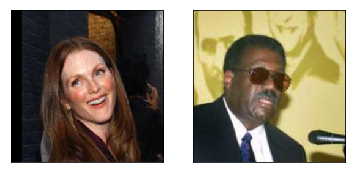

In [6]:
show_images(human_face_FN)

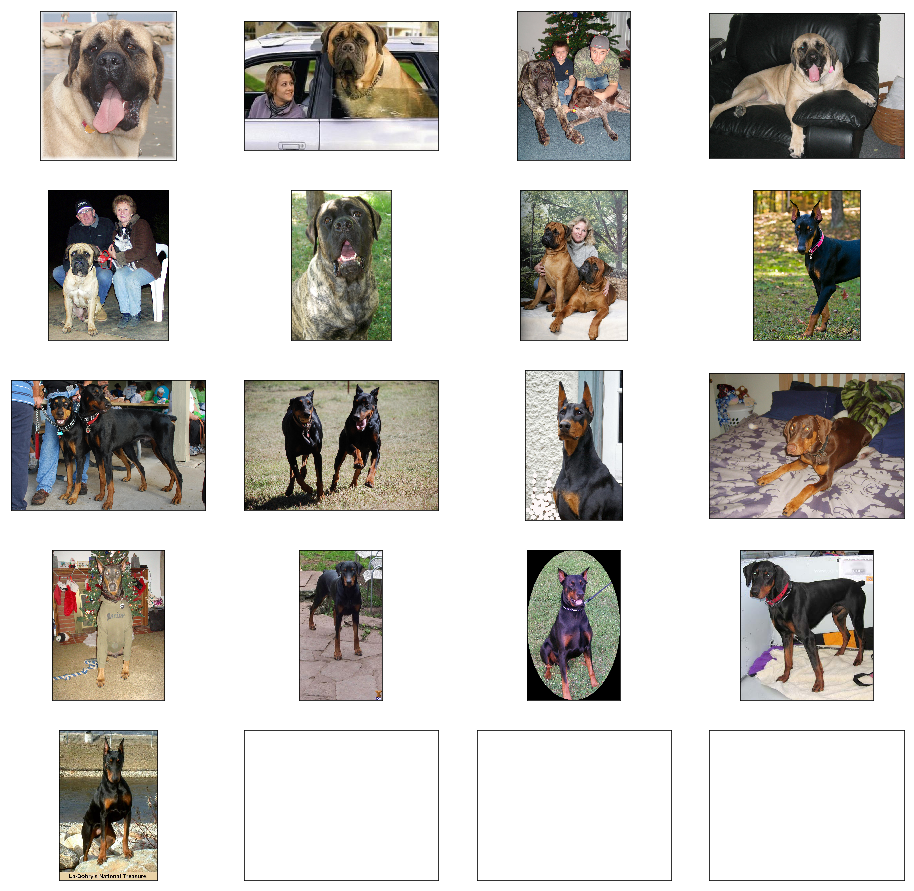

In [7]:
show_images(dog_face_FP)

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 93159330.15it/s] 


In [10]:
# check pytorch version
pytorch_ver = __version__.split('.')
pytorch_ver[0], pytorch_ver[1]

# this is pytorch version 0.4

('0', '4')

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
# Use this to address truncated files
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # NOTE: This code is taken from classifier.py which was part the AI Programming with Python 
    #       Nano degree I completed two years ago.
    
    
    # load the image
    img_pil = Image.open(img_path)
    
    #Preprocess
    # define transforms
    preprocess = transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])])
    
    # preprocess the image
    img_tensor = preprocess(img_pil)
    
    # resize the tensor (add dimension for batch)
    img_tensor.unsqueeze_(0)
    # since we are using a pretrained model and because thge PyTorch version is 0.4, 
    #   we set require_gradient to False. If we are using an earlier version, we will have
    #   to add additional code. 
    img_tensor.requires_grad_(False)
    
    # check for GPU. got errors without this when running on GPU
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # puts model in evaluation mode
    # instead of (default)training mode
    output = VGG16(img_tensor)
    
    # return index corresponding to predicted class
    if use_cuda:
        pred_idx = output.cpu().data.numpy().argmax()
    else:
        pred_idx = output.data.numpy().argmax()
    
    return pred_idx

225
/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg


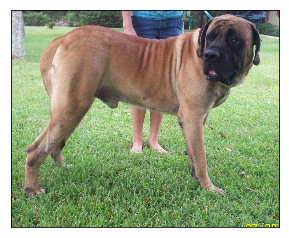

In [12]:
test_image = dog_files[0]
res = VGG16_predict(test_image)
print(res)
print(test_image)
show_images([test_image])

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred_idx = VGG16_predict(img_path)
    '''
    if pred_idx in range(151, 269):
        return True
    else:
        return False'''
    return pred_idx in range(151, 269)

In [14]:
dog_detector(test_image)

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ <br><br>
The Dog Detection algorithm did well with the dog pictures (90% correct (TP) and rejected most of the the human images (1% False Negative rate).<br>

>TP = 89<br>
>TN = 100<br>
>FP = 0<br>
>FN = 11<br>

We can calculate precision and recall from this.<br>

>Recall    = TP/(TP+FN) = 89/(89+11) = .89<br>
>Precision = TP/(TP+FP) = 90/(90+0) = 1.0<br>
>Specificity = TN/(TN + TP) = 100/(100+89) = .53<br>
>F1 = TP/(TP + .5(FP + FN)) = .94<br>

The Dog Detection algorithm is good at detecting the presence of dogs and it rarely mistakes humans for dogs. <br><br>
There are some patterns with False Negatives:<br>
>- Some of the images had more than one dog in them<br>
>- Other images contained large dogs that were various shades of light to dark brown<br>

This last observation is similiar to one for False Positives from Fact Detection algorithm. It seems that these large brown dogs such as mastiffs and doberman pinchers may be intepretted by these algorithms as humans. 

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

detect_dog_count_humans = 0
detect_dog_count_dogs   = 0
num_images              = len(human_files_short)
detect_dog_FN           = []
detect_dog_FP           = []

for i in range(num_images):
    if dog_detector(dog_files_short[i]):
        detect_dog_count_dogs += 1
    else:
        detect_dog_FN.append(dog_files_short[i])
    if dog_detector(human_files_short[i]):
        detect_dog_count_humans += 1
        detect_dog_FP.append(human_files_short[i])

print("Dog Detection in Dog Images: "+str(detect_dog_count_dogs)+"/"+str(num_images))
print("Dog Detection in Human Images: "+str(detect_dog_count_humans)+"/"+str(num_images))


Dog Detection in Dog Images: 89/100
Dog Detection in Human Images: 0/100


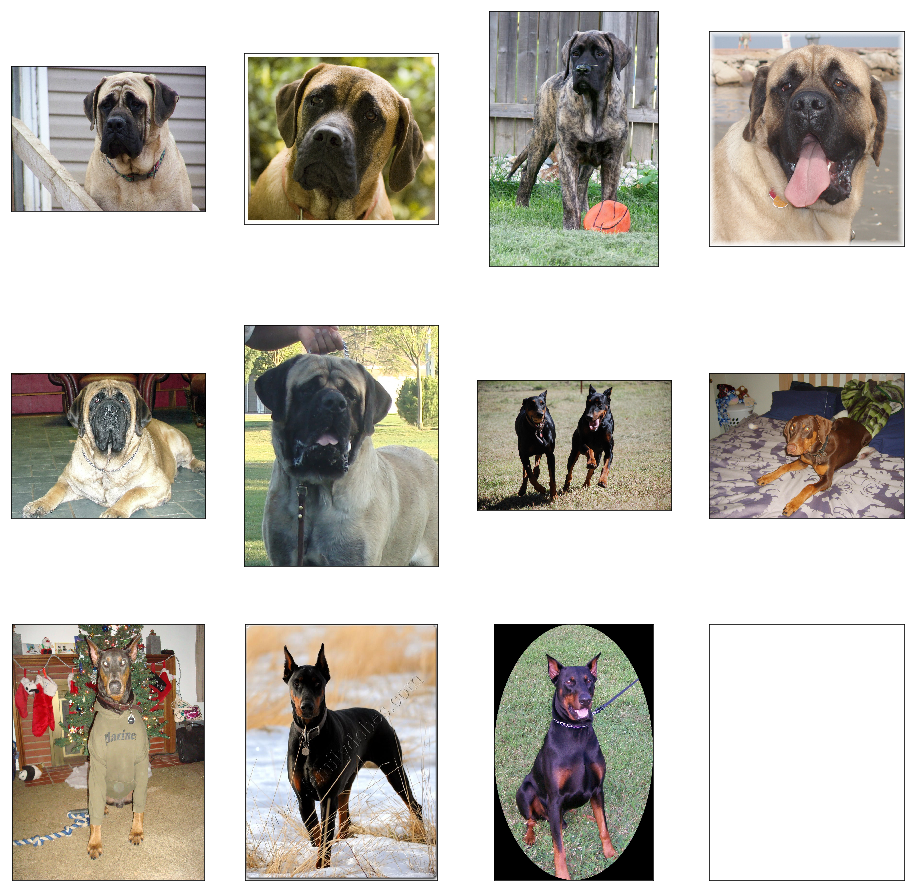

In [16]:
show_images(detect_dog_FN)

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [17]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

# I compared AlexNet, VGG, and resnet when I took the AI Programming with Python Nanodegree. Rather than 
#   rewrite code that I have already run, I will post the results. 
#
# I compared the three pre-trained algorithms using a set of 40 images. Some of these images contained
#   dogs and others had cats and other animals. 
#
# VGG performed best followed closely by resnet and then by AlexNet. The results are shown below
#
# Model     pct_match   pct_correct_dogs   pct_correct_breeds   pct_correct_notdogs
# AlexNet   75          100                80                   100
# VGG16     87.5        100                93.33                100
# resnet18  82.5        100                90                   90
#
# It should be noted that it appears that VGG took much longer to run than AlexNet or resnet. 
# If time is an issie, resnet might be a better choice, but VGG was more accurate.
# I will stick with VGG.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [9]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
    transforms.Resize(size=[256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
    transforms.Resize(size=[256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder(root='/data/dog_images/train', transform=transform_train)
valid_data = datasets.ImageFolder(root='/data/dog_images/valid', transform=transform_valid)
test_data  = datasets.ImageFolder(root='/data/dog_images/test', transform=transform_test)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(list(range(len(train_data))))
valid_sampler = SubsetRandomSampler(list(range(len(valid_data))))

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

loaders_scratch = {'train': train_loader,
                  'valid': valid_loader,
                  'test': test_loader}

In [19]:
len(train_data.classes)

# there are 133 classes

133

### **Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:<br><br> 
Training images are resized to 256x256 pixels and then randomly cropped to 224x224. This process makes the images square, sizes them correctly to be input into the model, slightly zooms the image, and has the effect of moving the dog around in the image. 224x224 is chosen because it is the input size of the VGG model. <br><br>

Training images are further augmented by random horizontal flipping and random rotation. These random augmentations should minimize image orientation as a detectable feature. <br><br>

Validation and Test images are resized to 256x256 and center cropped to 224x224. Augmentation is not used on either.  <br><br>

Finally, all dataset images are normalized.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [10]:
# define the CNN architecture
# this is a multilayer CNN with a three layer hidden layer. 

# use this to get more information when an exception occurs
CUDA_LAUNCH_BLOCKING=1

# this model achieved 15% accuracy with all the dropouts in the CNN layer
# it achieved 18% when removing those dropouts

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (256 * 7 * 7 -> 256 * 2 * 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 256 * 2 * 2 )
        # linear layer (256 * 2 * 2 -> 133)
        self.fc2 = nn.Linear(256 * 2 * 2, 133)
        
        # dropout layers 
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.15)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.25)
        self.dropout5 = nn.Dropout(0.3)
                              
    def forward(self, x):
        ## Define forward behavior
        
        # convolution, maxpooling, and dropout
        x = self.pool(F.relu(self.conv1(x))) # 112x112x16
        #x = self.dropout1(x)                 
        x = self.pool(F.relu(self.conv2(x))) # 56x56x32
        #x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x))) # 28x28x64
        #x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x))) # 14x14x128 
        #x = self.dropout4(x)
        x = self.pool(F.relu(self.conv5(x))) # 7x7x256
        x = self.dropout5(x)

        # flatten
        x = x.view(-1,256 * 7 * 7)
        
        # hidden layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
             
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ <br><br>
My design was driven by a few ideas:
>- I wanted to try more than 3 layers of CNNs and do something different
>- I started with a repeating pattern of CNNs and chose CNN -> MP -> Drop similiar to the CIFAR winner, but I found that removing the dropouts between the CNNs worked better. 
>- I wanted to use increasing levels of dropout like the CIFAR winner, but once I removed the dropouts between the CNNS this became unnecessary. 
>- I wanted to get the width and height down to a low number at the input of the flattening function, like 4 or in this case 7
>- I wanted to use default padding and strides
>- Since I was using more than 3 CNNs, I thought I might try a 2 layer hidden layer

Since the input size to the model is 224x224, to get it down to 7x7 using default padding and strides, I needed 5 layers (224->112->56->28->14->7).<br><br>

I chose a 2 layer hidden layer because the input vector seemed very large (12,544). I felt that it was important to use drop out between the hidden layers.<br><br> 

Observations and Comments:
>- Although I chose to use 5 layers, I think similiar results could have been obtained from a 3 layer network.
>- I ran this model a few times with and without dropout in the hidden layer and it appears that dropout in the hidden layer is very important. 
>- Also, I ran the model with and without dropout between the CNN layers and I found that it worked better without dropout in those layers.
>- It is really important to augment the training images. I got better results with I did this. 
>- It is important to process training, validation and test images the same way to get comparable test results. For this exercise, this means enlarging to 256x256 and then cropping to 224. This has the effect of zooming into the image  little bit.  

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [12]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
# increase lr from 0.01 to 0.05 to improve running time
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05) # I tried momentum but it never improved 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # TODO
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss

            #TODO
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [14]:
# train the model
# reduce epochs to 25 since lr was increased

if TRAIN_SCRATCH_MODEL:
    model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.884038 	Validation Loss: 4.867616
Validation loss decreased (inf --> 4.867616).  Saving model ...
Epoch: 2 	Training Loss: 4.868897 	Validation Loss: 4.841773
Validation loss decreased (4.867616 --> 4.841773).  Saving model ...
Epoch: 3 	Training Loss: 4.810883 	Validation Loss: 4.726019
Validation loss decreased (4.841773 --> 4.726019).  Saving model ...
Epoch: 4 	Training Loss: 4.746935 	Validation Loss: 4.577958
Validation loss decreased (4.726019 --> 4.577958).  Saving model ...
Epoch: 5 	Training Loss: 4.642838 	Validation Loss: 4.446093
Validation loss decreased (4.577958 --> 4.446093).  Saving model ...
Epoch: 6 	Training Loss: 4.560605 	Validation Loss: 4.426096
Validation loss decreased (4.446093 --> 4.426096).  Saving model ...
Epoch: 7 	Training Loss: 4.506336 	Validation Loss: 4.362213
Validation loss decreased (4.426096 --> 4.362213).  Saving model ...
Epoch: 8 	Training Loss: 4.436335 	Validation Loss: 4.187156
Validation loss decreased (4.36221

In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [26]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.446523


Test Accuracy: 18% (155/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [16]:
## TODO: Specify data loaders

# we can use the same data loaders since we are going to use VGG16
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

print(model_transfer)
print(model_transfer.classifier)
print(model_transfer.classifier[-1])
print(model_transfer.classifier[-1].in_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [18]:
# change the last model in VGG 
in_features = model_transfer.classifier[-1].in_features
model_transfer.classifier[-1] = nn.Linear(in_features=in_features, out_features=133)

# keep weights for all layers in VGG
for param in model_transfer.parameters():
    param.requires_grad = False
    
# except for the last one. we will optimize it
for param in model_transfer.classifier[-1].parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ <br><br>
I chose to use a pre-trained VGG16 model with the last hidden layer modified for dog breed detection.<br><br>

I chose to use a pre-trained VGG16 model for the following reasons:
>- I am already familiar with this model from the AI Programming with Python Nanodegree
>- This algorithm outperformed AlexNet and ResNet during tests I performed while persuing that Nanodegree
>- I wanted to see how much improvement could be made over the dog detection algorithm which used an unmodified VGG16 model  

I chose to replace and train only the last layer of the VGG16 model for the following reasons:
>- I did not think it would have been useful to specify an entirely new hidden layer
>- I did not want to retrain the entire model 

I am using the same loaders as defined earlier for the following reasons:
>- I did not want to write new code
>- It is helpful for comparisons between the scratch and transfer learning models

I think the architecture is suitable for this problem.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [19]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier[-1].parameters(), lr=0.05)

# we'll use the same optimzer as we did earlier
# only optimize the past layer and not the entire model

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model

if TRAIN_TRANSFER_MODEL:
    model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.167678 	Validation Loss: 0.780194
Validation loss decreased (inf --> 0.780194).  Saving model ...
Epoch: 2 	Training Loss: 1.628120 	Validation Loss: 0.761948
Validation loss decreased (0.780194 --> 0.761948).  Saving model ...
Epoch: 3 	Training Loss: 1.620831 	Validation Loss: 0.723226
Validation loss decreased (0.761948 --> 0.723226).  Saving model ...
Epoch: 4 	Training Loss: 1.632986 	Validation Loss: 0.705127
Validation loss decreased (0.723226 --> 0.705127).  Saving model ...
Epoch: 5 	Training Loss: 1.639195 	Validation Loss: 0.660557
Validation loss decreased (0.705127 --> 0.660557).  Saving model ...
Epoch: 6 	Training Loss: 1.594692 	Validation Loss: 0.694122
Epoch: 7 	Training Loss: 1.603423 	Validation Loss: 0.787556
Epoch: 8 	Training Loss: 1.607046 	Validation Loss: 0.737182
Epoch: 9 	Training Loss: 1.563223 	Validation Loss: 0.717790
Epoch: 10 	Training Loss: 1.614403 	Validation Loss: 0.680200
Epoch: 11 	Training Loss: 1.584164 	Validation Lo

In [17]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [33]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.838123


Test Accuracy: 84% (703/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [22]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    '''
    Use transfer learning VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to the transfer learning VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # NOTE: This code is taken from classifier.py which was part the AI Programming with Python 
    #       Nano degree I completed two years ago.
    
    
    # load the image
    img_pil = Image.open(img_path)
    
    #Preprocess
    # define transforms
    preprocess = transforms.Compose([
        transforms.Resize(size=[256,256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    # preprocess the image
    img_tensor = preprocess(img_pil)
    
    # resize the tensor (add dimension for batch)
    img_tensor.unsqueeze_(0)
    # since we are using a pretrained model and because thge PyTorch version is 0.4, 
    #   we set require_gradient to False. If we are using an earlier version, we will have
    #   to add additional code. 
    img_tensor.requires_grad_(False)
    
    # check for GPU. got errors without this when running on GPU
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # puts model in evaluation mode
    # instead of (default)training mode
    output = model_transfer(img_tensor)
    
    # return index corresponding to predicted class
    if use_cuda:
        pred_idx = output.cpu().data.numpy().argmax()
    else:
        pred_idx = output.data.numpy().argmax()
    
    return pred_idx

40
Bullmastiff
/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
58
Doberman pinscher
/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04172.jpg
101
Manchester terrier
/data/dog_images/train/102.Manchester_terrier/Manchester_terrier_06779.jpg
39
Bulldog
/data/dog_images/train/040.Bulldog/Bulldog_02823.jpg


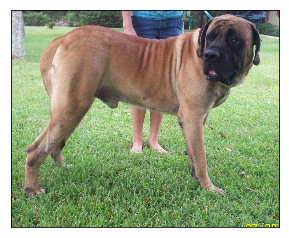

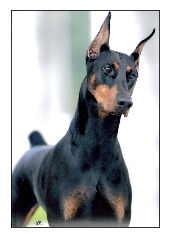

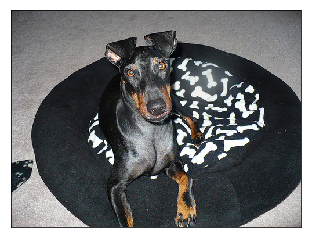

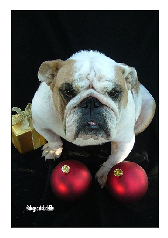

In [67]:
test_images=[dog_files[0], dog_files[100], dog_files[1000], dog_files[5000]]
for test_image in test_images:
    show_images([test_image])
    result = predict_breed_transfer(test_image)
    print(result)
    print(class_names[result])
    print(test_image)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [35]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    dog_breed_idx = predict_breed_transfer(img_path)
    dog_breed     = class_names[dog_breed_idx]
    
    if face_detector(img_path) and dog_detector(img_path):
        print("Human and dog detected. The detected dog might be a "+dog_breed+".")
    elif face_detector(img_path):
        print("Human detected. The human resembles a "+dog_breed+".")
    elif dog_detector(img_path):
        print("Dog detected. It appears to be a "+dog_breed+".")
    else:
        print("Error: Neither dog nor human detected, but it is possible that the image is of a "+dog_breed+".")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ <br><br>
The algorithm performs as expected. It correctly detected humans in the test images that were provided. It appears to also have correctly identified the dog breeds for the test images in which it detected a dog.<br><br>

This algorith is not expected to be perfect. In fact, while the face detection algorithm is really good at detecting human faces when present, it sometimes mistakes dog faces as human. As a result, we expect about ~15% of the images with dogs to be falsely labeled as humans., including images of large, dark brown dogs.<br><br>

From the earlier testing, we can expect the algorithm to correctly identify the breed of dog for ~85% of the dog images. This is quite good!<br><br>

The algorithm performs well for images in which there is a single dog or human, but not when there are multiple dogs and/or humans.<br><br> 

There are some areas where the algorithm can be improved:
>- We need a way to detect the presence of more than one dog and/or human in the photo
>- We need a way to reconcile situations where algorithm detects, for images with a single dog or human, the presence of human and dog. Which do we pick? 
>- There may be some biases in the training, validation, and test images that could be improved upon. For example, the face detection algoritm did not detect one of the images below (the last one) that is obviously a human. 
>- The dog detector algorithm can be improved by using transfer learning rathern than the unmodified VGG16. 
>- The dog detector algorithm could be improved by taking class imbalance into account. 

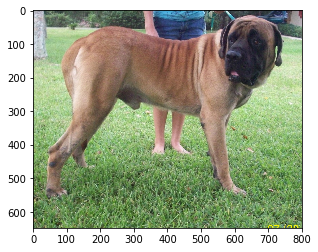

Dog detected. It appears to be a Bullmastiff.


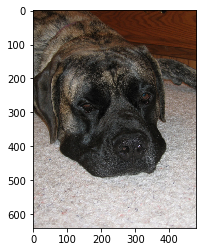

Dog detected. It appears to be a Mastiff.


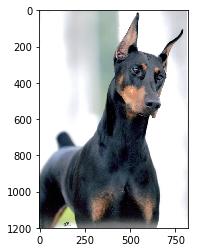

Error: Neither dog nor human detected, but it is possible that the image is of a German pinscher.


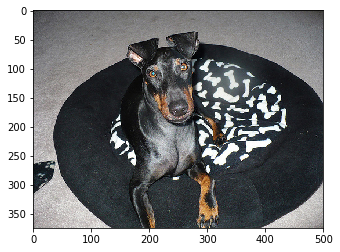

Dog detected. It appears to be a Manchester terrier.


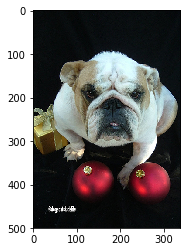

Dog detected. It appears to be a Bulldog.


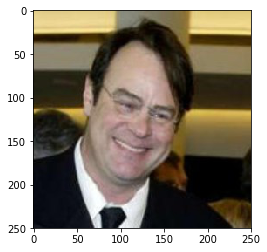

Human detected. The human resembles a Chihuahua.


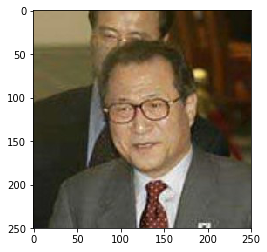

Human detected. The human resembles a Field spaniel.


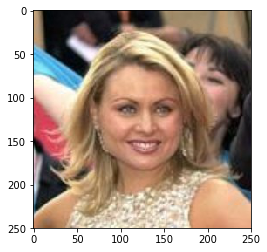

Human detected. The human resembles a Lowchen.


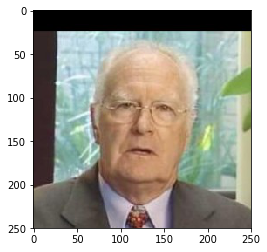

Human detected. The human resembles a Brittany.


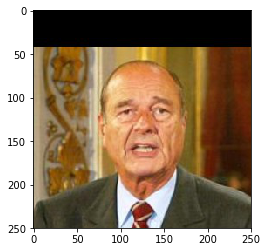

Human detected. The human resembles a Beagle.


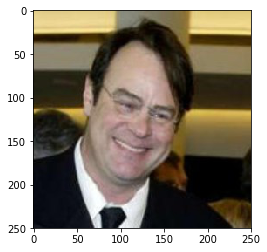

Human detected. The human resembles a Australian shepherd.


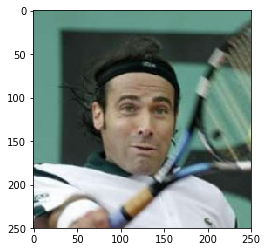

Human detected. The human resembles a Collie.


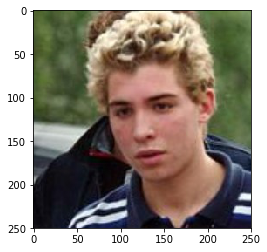

Human detected. The human resembles a Otterhound.


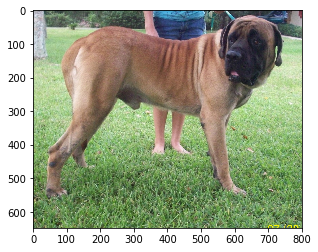

Dog detected. It appears to be a Bullmastiff.


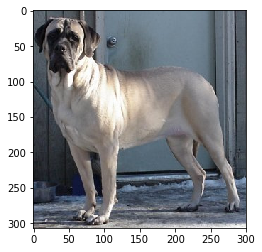

Dog detected. It appears to be a Bullmastiff.


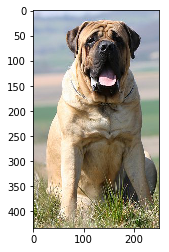

Dog detected. It appears to be a Bullmastiff.


In [36]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below

final_test_set = [dog_files[0], dog_files[10], dog_files[100], dog_files[1000], dog_files[5000],
                 human_files[0], human_files[10], human_files[100], human_files[1000], human_files[5000]]

for final_test_image in final_test_set:
    run_app(final_test_image)

for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

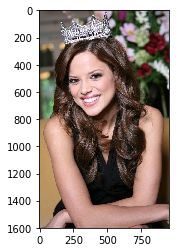

Human detected. The human resembles a Havanese.


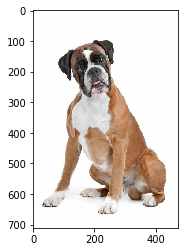

Dog detected. It appears to be a Boxer.


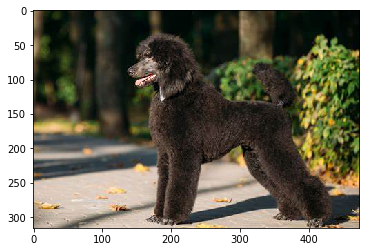

Dog detected. It appears to be a Poodle.


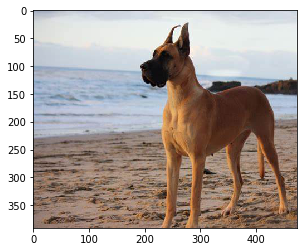

Dog detected. It appears to be a Great dane.


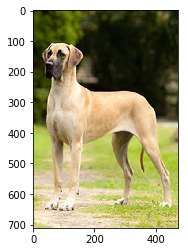

Dog detected. It appears to be a Great dane.


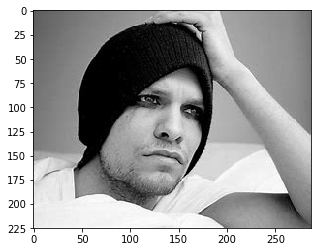

Human detected. The human resembles a Dachshund.


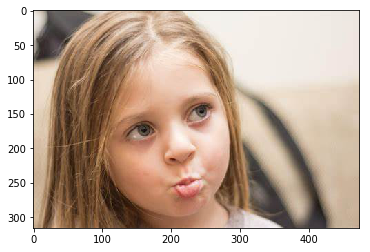

Human detected. The human resembles a Havanese.


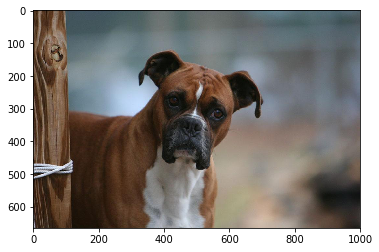

Dog detected. It appears to be a Boxer.


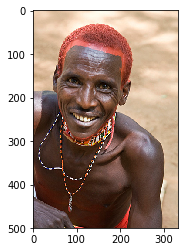

Error: Neither dog nor human detected, but it is possible that the image is of a Pharaoh hound.


In [37]:
# test on some images from the internet

my_images = np.array(glob('my_images/*'))
for idx, img_file in enumerate(my_images):
    run_app(img_file)
    